**Data Extraction and Preparation**

In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
from platform import python_version

print('The Python version is {}.'.format(python_version()))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print()

#Extract the data from train.csv into Xy_train
data = pd.read_csv('Telco-Customer-Churn.csv', engine='python')

# Find and Remove all the data with empty string 
data.replace(' ', np.nan, inplace=True)
data.isnull().sum() # TotalCharges - 11
data = data.dropna()

# Tenure to categorical column - This is done to get a better understanding in a group sense
def tenure_categorical(telcom) :
    if telcom['tenure'] <= 12 :
        return "tenure_0-12"
    elif (telcom['tenure'] > 12) & (telcom['tenure'] <= 24 ):
        return "tenure_12-24"
    elif (telcom['tenure'] > 24) & (telcom['tenure'] <= 48) :
        return "tenure_24-48"
    elif (telcom['tenure'] > 48) & (telcom['tenure'] <= 60) :
        return "tenure_48-60"
    elif telcom['tenure'] > 60 :
        return "tenure_gt_60"

data["tenure"] = data.apply(lambda data:tenure_categorical(data),
                                      axis = 1)

# Customer ID does not provide any relevant info and hence, is dropped. 
x = data.drop(columns=['customerID', 'Churn'])
y = data.Churn

# No = 0 while Yes = 1 for Churn
y = y.apply(lambda x: 0 if x.strip()=='No' else 1)


# See the number of observation for Yes or No
print("Churn: Yes = 1, No = 0")
print(y.value_counts())
print()


# Splitting the data into 70% of training data and 30% of testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state =0)

# NULL Accuracy: Accuracy that could be achieved by always predicting the most frequent clas in test class
print( "The NULL Accuracy for test set :" + str(max(y_test.mean(), 1 - y_test.mean())))
# If our model only predicts 'No' for every observation, it would have an accuracy of 0.7369668246445498

#Showcasing the transformed data used for testing
print()
x.head()

The Python version is 3.6.9.
The scikit-learn version is 0.22.2.post1.

Churn: Yes = 1, No = 0
0    5163
1    1869
Name: Churn, dtype: int64

The NULL Accuracy for test set :0.7369668246445498



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,tenure_0-12,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,tenure_24-48,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,Male,0,No,No,tenure_0-12,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,tenure_24-48,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,tenure_0-12,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


**Data Preprocessing**

In [0]:
# ------- Data Preprocessing ------- #

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


numeric_features = ['MonthlyCharges', 'TotalCharges','SeniorCitizen']

categorical_features = ['gender', 'Partner',  'PaymentMethod',
                        'Dependents', 'PhoneService', 'MultipleLines',
                        'Contract', 'PaperlessBilling', 'OnlineSecurity',
                        'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'tenure'
                        ]

# Standard Scaling for numeric features to scale the features to a range (centered around zero) 
# to achieve the variance of the features in the same range. If a feature’s variance is orders 
# of magnitude more than the variance of other features, that particular feature might dominate 
# other features in the dataset.         
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

# One hot encoding done on categorical variables so that they are converted into a form that could 
# be provided to ML algorithms. Label Encoding is not used as there is no relation between features
# eg. if Male is 0 and Female 1 than Female is not greater than Male.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Applying the transformation mentioned above to the features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

x_train = x_train[[*numeric_features, *categorical_features]]

x_test = x_test[[*numeric_features, *categorical_features]]

# For retreiving name for the features after onehotencoding
encoder = OneHotEncoder()
train_X_encoded = encoder.fit_transform(x_train[[*categorical_features]])

feature_names = np.append(numeric_features , encoder.get_feature_names([*categorical_features]) )

**Decision Tree Model Fitting**

In [7]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Balanced Class Weights allow us to work better with Unbalanced Classes
regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', DecisionTreeClassifier(class_weight='balanced', random_state=0))])

# Paramters for Hypertuning using GridSearchCV
# Commented out means goes to default value
param_grid = {
    'regressor__max_features': [5, 10, 15, 19, 20, 25],
    'regressor__min_samples_leaf': [1, 5, 10, 20, 50, 100],
    #'regressor__splitter' : ['best', 'random'],
    #'regressor__max_depth': np.arange(1, 21),
    #'regressor__criterion': ['gini', 'entropy']
}

# Scoring F1-Score based on our report objective
grid_search_dtree = GridSearchCV(
    regr, param_grid, cv=5, verbose=3, n_jobs=-1, 
    scoring='f1_macro')

grid_search_dtree.fit(x_train, y_train)

# Average of Macro f1-score scores on left-out test folds for the best parameter combination.
print()
print('best score {}'.format(grid_search_dtree.best_score_))
print()
# Best parameter combination for the model
print('best parameter {}'.format(grid_search_dtree.best_estimator_['regressor']))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    8.1s



best score 0.710610464411914

best parameter DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=15, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.3s finished


**Visualization of Decision Tree**

In [0]:
# Post-pruning for Decision Tree
# Taken from https://stackoverflow.com/questions/51397109/prune-unnecessary-leaves-in-sklearn-decisiontreeclassifier

# Prune all the children of the node if they make the same decision 
# eg. All Children of Month-to-Month Contract node leads to Churn value of 0 or N and hence, all of its children are pruned.

from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

prune_duplicate_leaves(grid_search_dtree.best_estimator_['regressor'])

In [10]:

from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call

# Export as dot file 
##    class_names should match label numbers in ascending numeric order
export_graphviz(grid_search_dtree.best_estimator_['regressor'], out_file='tree.dot',
                rounded = True, proportion = False, feature_names = feature_names,class_names = ['No', 'Yes'],
                precision = 2, filled = True)

# Convert to png using system command
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
Image(filename = 'tree.png')


**Feature Importance**

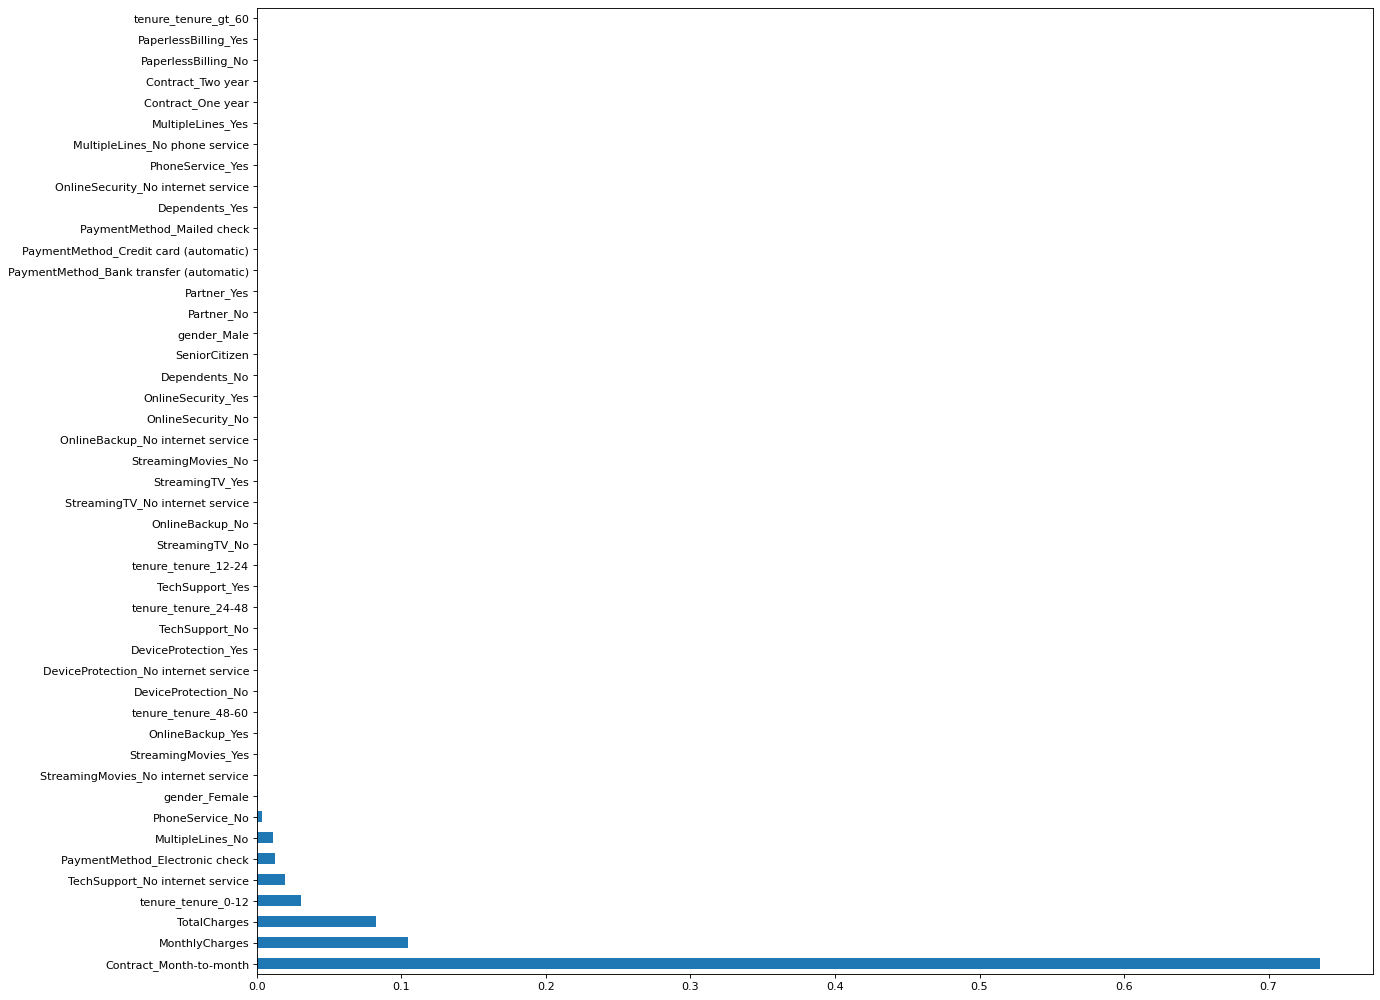

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# biased approach, as it has a tendency to inflate the importance of continuous features
# or high-cardinality categorical variables

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

(pd.Series(grid_search_dtree.best_estimator_['regressor'].feature_importances_, index=feature_names)
   .nlargest(46)
   .plot(kind='barh'))

**Confusion Matrix of Decision Tree**

In [13]:
from sklearn.metrics import classification_report

y_train_pred_dtree = grid_search_dtree.predict(x_train)
print("----------TRAIN----------")
print(classification_report(y_train, y_train_pred_dtree,  digits=4))

y_pred_dtree = grid_search_dtree.predict(x_test)
print("-----------TEST----------")
print(classification_report(y_test, y_pred_dtree,  digits=4))


----------TRAIN----------
              precision    recall  f1-score   support

           0     0.8925    0.7711    0.8274      3608
           1     0.5424    0.7451    0.6278      1314

    accuracy                         0.7641      4922
   macro avg     0.7175    0.7581    0.7276      4922
weighted avg     0.7990    0.7641    0.7741      4922

-----------TEST----------
              precision    recall  f1-score   support

           0     0.8862    0.7659    0.8217      1555
           1     0.5248    0.7243    0.6086       555

    accuracy                         0.7550      2110
   macro avg     0.7055    0.7451    0.7151      2110
weighted avg     0.7911    0.7550    0.7656      2110



**Logistic Regression Model Fitting** 

In [0]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LogisticRegression(class_weight='balanced', random_state=0))])

# Commented out means goes to default value
param_grid = {
    'regressor__C': [0.001,.009,0.01,.09,1,5,10,25],
    #'regressor__penalty' : ['l1', 'l2','elasticnet'],
    'regressor__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    #'regressor__fit_intercept': [True, False]
    #'regressor__l1_ratio': [0, 0.0001,0.001,0.01,.09,1] as penalty is NOT elasticnet
}

grid_search_log = GridSearchCV(
    regr, param_grid, cv=5, verbose=3, n_jobs=-1, 
    scoring='f1_macro')

grid_search_log.fit(x_train, y_train)

print()
print('best score {}'.format(grid_search_log.best_score_))
print()
print('best parameter {}'.format(grid_search_log.best_estimator_['regressor']))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.4s



best score 0.7190481780113396

best parameter LogisticRegression(C=0.09, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   18.6s finished


In [0]:
# The list of coefficient values for all features for Logistic Regression
weights = grid_search_log.best_estimator_['regressor'].coef_[0]

# coefficients that have the largest positive value push the probability towards  1 (Yes)
# and negative push the probability towards  0 (No)
cols = ['Feature', 'Coefficient']
lst = []

for i in range(len(weights)):
  lst.append([feature_names[i], weights[i]])
df1 = pd.DataFrame(lst, columns=cols)

# Sort based on absolute value of Coefficient
df1.iloc[(-df1['Coefficient'].abs()).argsort()].reset_index(drop=True)


,Feature,Coefficient
0,MonthlyCharges,0.870092
1,tenure_tenure_0-12,0.831217
2,Contract_Month-to-month,0.795952
3,Contract_Two year,-0.788694
4,tenure_tenure_gt_60,-0.384346
5,PaymentMethod_Electronic check,0.323946
6,TotalCharges,-0.273007
7,TechSupport_Yes,-0.244481
8,OnlineSecurity_Yes,-0.238358
9,PaymentMethod_Credit card (automatic),-0.227782


**Confusion Matrix of Logistic Regression**

In [0]:
from sklearn.metrics import classification_report

y_train_pred_log = grid_search_log.predict(x_train)
print("----------TRAIN----------")
print(classification_report(y_train, y_train_pred_log,  digits=4))

y_pred_log = grid_search_log.predict(x_test)
print("-----------TEST----------")
print(classification_report(y_test, y_pred_log,  digits=4))


----------TRAIN----------
              precision    recall  f1-score   support

           0     0.9077    0.7328    0.8109      3608
           1     0.5202    0.7953    0.6289      1314

    accuracy                         0.7495      4922
   macro avg     0.7139    0.7640    0.7199      4922
weighted avg     0.8042    0.7495    0.7623      4922

-----------TEST----------
              precision    recall  f1-score   support

           0     0.9043    0.7415    0.8148      1555
           1     0.5186    0.7802    0.6230       555

    accuracy                         0.7517      2110
   macro avg     0.7114    0.7608    0.7189      2110
weighted avg     0.8028    0.7517    0.7644      2110



**K-Nearest Neighbors Model Fitting** 

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', KNeighborsClassifier())])

param_grid = {
    'regressor__n_neighbors': range(1,47),
    'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'regressor__metric': ['euclidean', 'manhattan','chebyshev','minkowski', 'seuclidean'],
    'regressor__weights': ['uniform', 'distance']
}

grid_search_KN = GridSearchCV(
    regr, param_grid, cv=5, verbose=3, n_jobs=-1, 
    scoring='f1_macro')

grid_search_KN.fit(x_train, y_train)

print()
print('best score {}'.format(grid_search_KN.best_score_))
print()
print('best parameter {}'.format(grid_search_KN.best_estimator_['regressor']))

Fitting 5 folds for each of 1840 candidates, totalling 9200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2396 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2940 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 3548 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 4282 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 5294 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 6094 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 7456 tasks      | elapsed: 24.2min



best score 0.7285707765344088

best parameter KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=41, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Done 9200 out of 9200 | elapsed: 29.4min finished


**Confusion Matrix of K-Nearest Neighbors**

In [0]:
from sklearn.metrics import classification_report

y_train_pred_KN = grid_search_KN.predict(x_train)
print("----------TRAIN----------")
print(classification_report(y_train, y_train_pred_KN,  digits=4))

y_pred_KN = grid_search_KN.predict(x_test)
print("-----------TEST----------")
print(classification_report(y_test, y_pred_KN,  digits=4))

----------TRAIN----------
              precision    recall  f1-score   support

           0     0.8562    0.8647    0.8605      3608
           1     0.6182    0.6012    0.6096      1314

    accuracy                         0.7944      4922
   macro avg     0.7372    0.7330    0.7350      4922
weighted avg     0.7927    0.7944    0.7935      4922

-----------TEST----------
              precision    recall  f1-score   support

           0     0.8454    0.8547    0.8500      1555
           1     0.5799    0.5622    0.5709       555

    accuracy                         0.7777      2110
   macro avg     0.7127    0.7084    0.7105      2110
weighted avg     0.7756    0.7777    0.7766      2110



**ROC & AUC**

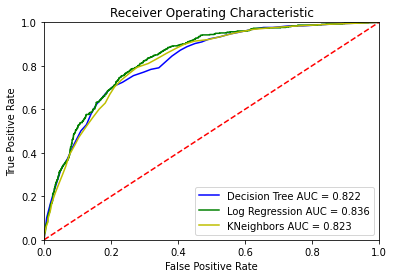

In [0]:
import sklearn.metrics as metrics

# Decision Tree
# Do not use y_pred, because it will give incorrect results without generating an error
probs_dtree = grid_search_dtree.predict_proba(x_test)
# store the predicted probabilities for class 1 (Class 1 is predicted if probability > 0.5)
preds_dtree = probs_dtree[:,1]
fpr_dtree, tpr_dtree, threshold_dtree = metrics.roc_curve(y_test, preds_dtree)
roc_auc_dtree = metrics.auc(fpr_dtree, tpr_dtree)

# Logistic Regression
probs_log = grid_search_log.predict_proba(x_test)
preds_log = probs_log[:,1]
fpr_log, tpr_log, threshold_log = metrics.roc_curve(y_test, preds_log)
roc_auc_log = metrics.auc(fpr_log, tpr_log)

# KNeighbors
probs_KN = grid_search_KN.predict_proba(x_test)
preds_KN = probs_KN[:,1]
fpr_KN, tpr_KN, threshold_KN = metrics.roc_curve(y_test, preds_KN)
roc_auc_KN = metrics.auc(fpr_KN, tpr_KN)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_dtree, tpr_dtree, 'b', label = 'Decision Tree AUC = %0.3f' % roc_auc_dtree)
plt.plot(fpr_log, tpr_log, 'g', label = 'Log Regression AUC = %0.3f' % roc_auc_log)
plt.plot(fpr_KN, tpr_KN, 'y', label = 'KNeighbors AUC = %0.3f' % roc_auc_KN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


**Overall Results**

In [0]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
import plotly
import plotly.figure_factory as ff
import plotly.offline as py


# Gives model report in dataframe
def model_report(pred,y_test,fpr,tpr,name) :
    temp = classification_report(y_test, pred,  digits=4, output_dict=True)
    # Macro Avg is used in order bigger penalisation when your model does not perform well with 
    # the minority classes (in this case Yes for Churn)
    accuracy_test= temp['accuracy']
    recallscore  = temp['macro avg']['recall']
    precision    = temp['macro avg']['precision']
    roc_auc      = metrics.auc(fpr, tpr)
    f1score      = temp['macro avg']['f1-score']

    df = pd.DataFrame({"Model"           : [name],
                          "Accuracy (Test)"  : [accuracy_test],
                          "Recall"    : [recallscore],
                          "Precision"       : [precision],
                          "F1-score"        : [f1score],
                          "Area under curve (AUC)": [roc_auc],
                          })
    return df

model1 = model_report(y_pred_dtree,y_test,fpr_dtree, tpr_dtree,
                      "Decision Tree")

model2 = model_report(y_pred_log,y_test,fpr_log, tpr_log,
                      "Logistic Regression")


model3 = model_report(y_pred_KN,y_test,fpr_KN, tpr_KN,
                      "K-Nearest Neighbors")

model_performances = pd.concat([model1,model2,model3],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

%matplotlib inline
py.iplot(table)